# SG-MCMC Sampling - Hands-on
This notebook implements sgmcmc samplers to test them on simple landscapes. So we are able to get a feeling for their differences and behavior.

In [1]:
import jax
import jax.numpy as jnp
import tqdm
import os

from enhancing_sgmcmc.samplers.sghmc import SGHMC
from enhancing_sgmcmc.utils import (
    gaussian_mixture_logprob,
    plot_gaussian_mixture_sampling,
    run_sghmc_experiment,
)

In [2]:
os.chdir("../..")

In [3]:
%load_ext autoreload
%autoreload 2

### Setup

In [24]:
means = jnp.array([[-4.0, -4.0], [4.0, 4.0], [4.0, -4.0], [-4.0, 4.0]])
covs = jnp.array(
    [
        [[4, 0.0], [0.0, 4]],
        [[4, 0.0], [0.0, 8]],
        [[8, 0.0], [0.0, 3]],
        [[2, 0.0], [0.0, 5]],
    ]
)
weights = jnp.array([0.25, 0.25, 0.25, 0.25])

In [25]:
def grad_estimator(position, x=None, y=None):
    """Gradient estimator for Gaussian mixture model."""
    # In this example, x and y are not used as we're directly sampling from a distribution
    logprob = gaussian_mixture_logprob(position, means, covs, weights)
    return logprob, jax.grad(gaussian_mixture_logprob)(position, means, covs, weights)

In [26]:
sampler = SGHMC(grad_estimator)
init_position = jnp.array([0.0, 0.0])  # Start at the origin

100%|██████████| 3/3 [01:48<00:00, 36.13s/it]


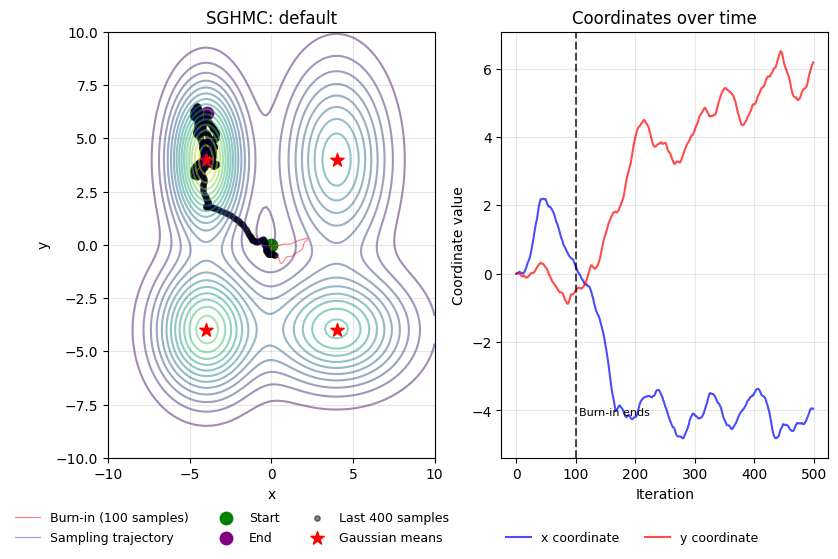

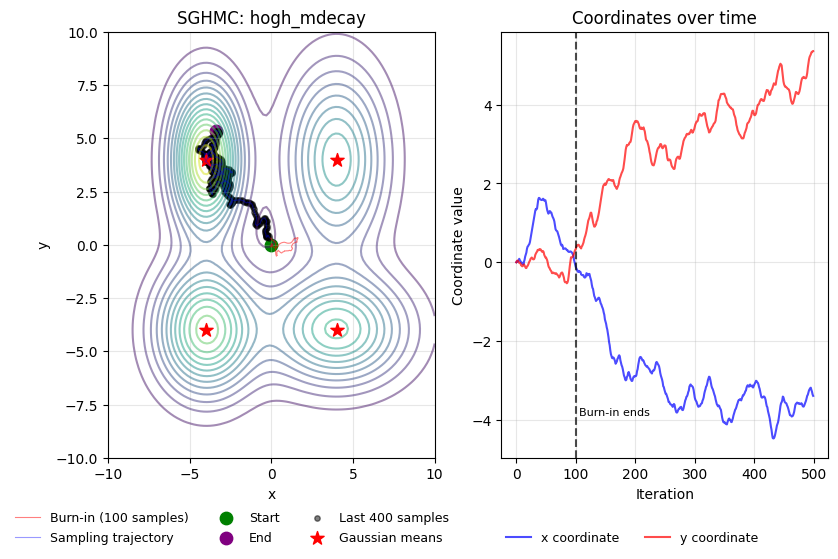

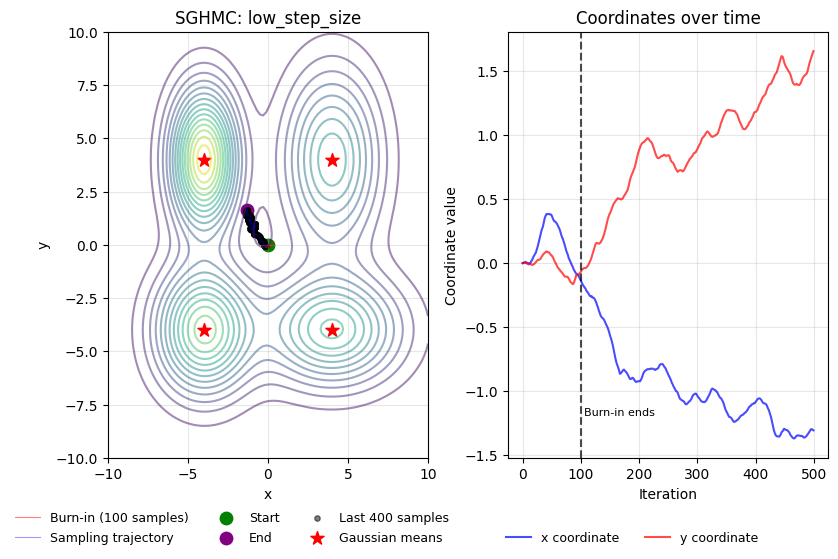

In [28]:
# Example usage
experiment_configs = [
    {
        "name": "default",
        "step_size": 0.05,
        "mdecay": 0.05,
        "burnin": 100,
    },
    {
        "name": "hogh_mdecay",
        "step_size": 0.05,
        "mdecay": 0.2,
        "burnin": 100,
    },
    {
        "name": "low_step_size",
        "step_size": 0.01,
        "mdecay": 0.05,
        "burnin": 100,
    },
]

# Run experiments
for config in tqdm.tqdm(experiment_configs):
    trajectory = run_sghmc_experiment(
        sampler=sampler,
        init_position=init_position,
        num_samples=500,
        step_size=config["step_size"],
        mdecay=config["mdecay"],
        num_integration_steps=1,
        mresampling=0.01,
    )

    fig, axes = plot_gaussian_mixture_sampling(
        trajectory=trajectory,
        means=means,
        covs=covs,
        weights=weights,
        gaussian_mixture_logprob=gaussian_mixture_logprob,
        title=f"SGHMC: {config['name']}",
        burnin=config["burnin"],
        figsize=(8, 5),
    )

    fig.savefig(
        f"results/sghmc_{config['name'].replace(' ', '_')}.png", dpi=300, bbox_inches="tight"
    )